In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn 
import scipy.signal as signal


# Set data type and device
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())
#device = torch.device("cpu")

# Close all open plots
plt.close('all')

True


In [7]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
nExp = yExp.size


In [8]:
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 5)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 4

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = (torch.from_numpy(dExp[0, j]))
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))            # to smooth the input signal of Qhot (noisy)

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [9]:
#Set dimensions for RNN layers
idd = dExp[0, 0].shape[1]
hdd = 100 #  ->150-200
ldd = 1#     ->1
odd = yExp[0, 0].shape[1]

# Initialize RNN model
LTS = LSTModel(idd, hdd, ldd, odd)

# Load the model parameters before starting a new training session
#LTS.load_state_dict(torch.load('parameters_LSTM.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 300

# Initialize array to store loss values
LOSS = np.zeros(epochs)


In [10]:
""" 
# Define loss log file path
loss_log_path = "loss_log.npy"

# Check if loss log file exists; if so, load it, otherwise create an empty list
if os.path.exists(loss_log_path):
    cumulative_loss = list(np.load(loss_log_path))
else:
    cumulative_loss = []
"""
    
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    
    # Get RNN output for training data
    yLTS = LTS(u)
    yLTS = torch.squeeze(yLTS)
    
    # Calculate loss and backpropagate
    loss = MSE(yLTS, y)
    loss.backward()
    optimizer.step()
 
    # Save the cumulative loss array
    #cumulative_loss.append(float(loss))
    #np.save(loss_log_path, np.array(cumulative_loss))

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(LTS.state_dict(), f'parameters_LSTM.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")

Epoch: 1 	||	 Loss: 0.3734496235847473
Epoch: 2 	||	 Loss: 0.1063772663474083
Epoch: 3 	||	 Loss: 0.6031866073608398
Epoch: 4 	||	 Loss: 0.024889547377824783
Epoch: 5 	||	 Loss: 0.10325346887111664
Epoch: 6 	||	 Loss: 0.14020632207393646
Epoch: 7 	||	 Loss: 0.14749601483345032
Epoch: 8 	||	 Loss: 0.13702137768268585
Epoch: 9 	||	 Loss: 0.1149136945605278
Epoch: 10 	||	 Loss: 0.0848335474729538
Epoch: 11 	||	 Loss: 0.0506034716963768
Epoch: 12 	||	 Loss: 0.019811414182186127
Epoch: 13 	||	 Loss: 0.00854703038930893
Epoch: 14 	||	 Loss: 0.026383064687252045
Epoch: 15 	||	 Loss: 0.031995855271816254
Model parameters saved at epoch 15
Epoch: 16 	||	 Loss: 0.022007783874869347
Epoch: 17 	||	 Loss: 0.01188641507178545
Epoch: 18 	||	 Loss: 0.007422755006700754
Epoch: 19 	||	 Loss: 0.007270681671798229
Epoch: 20 	||	 Loss: 0.008855382911860943
Epoch: 21 	||	 Loss: 0.01044054888188839
Epoch: 22 	||	 Loss: 0.011246537789702415
Epoch: 23 	||	 Loss: 0.01112719252705574
Epoch: 24 	||	 Loss: 0.01027

In [11]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 5)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
yLTS_val = LTS(uval)
#yLTS_val = yLTS_val.unsqueeze_(0)

# Calculate loss for validation data
loss_val = MSE(yLTS_val[:,10:,:], yval[:,10:,:])

In [12]:
# After training, you can plot the cumulative loss
plt.plot(cumulative_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show() 

NameError: name 'cumulative_loss' is not defined

In [41]:
# test :
# Initialize input and output tensors for validation data
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, 5)
yval = torch.zeros(nExp, t_end, 2)
yLTS = torch.zeros(nExp, t_end, 2)
yLTS_val= torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    for i in range(2):
    
        yLTS[j, :, i] = torch.from_numpy(signal.medfilt((y[j, :, i]).numpy(), 15))
        yLTS_val[j, :, i] = torch.from_numpy(signal.medfilt((yval[j, :, i]).numpy(), 15))
        


    # Adding small random values to the last two rows
    noise_yLTS = torch.randn(t_end, yLTS.shape[2]) * 0.0015  # Adjust the scale as needed
    noise_yLTS_val = torch.randn(t_end, yLTS_val.shape[2]) * 0.0015

    # Add noise to the last two rows of yLTS and yLTS_val
    yLTS[j, :, :] += noise_yLTS
    yLTS_val[j, :, :] += noise_yLTS_val


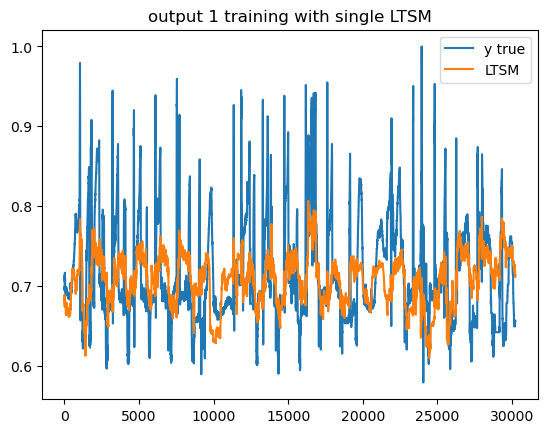

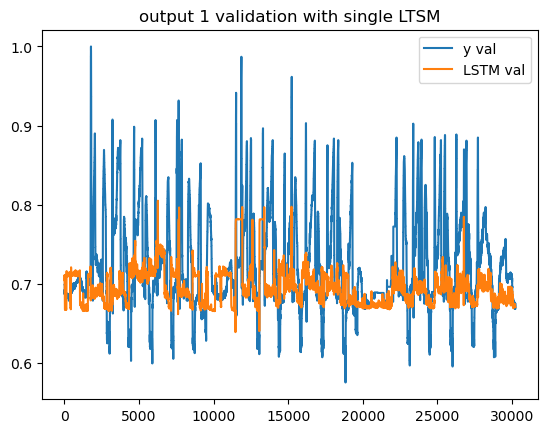

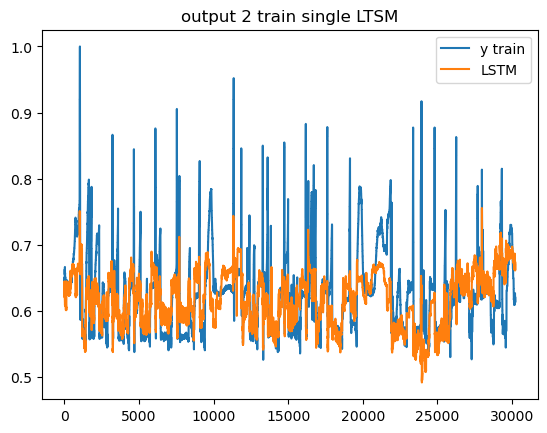

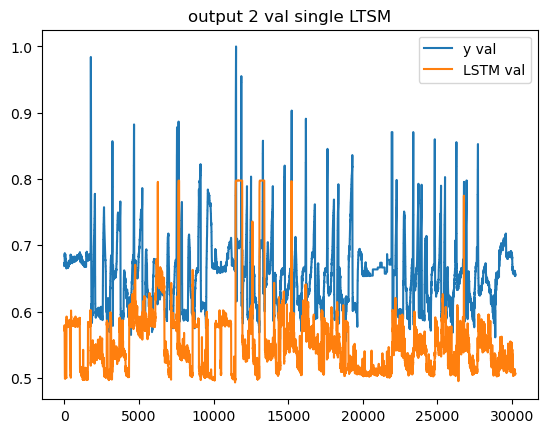

In [12]:
# Plot loss over epochs
#plt.figure('8')
#plt.semilogy(LOSS)
#plt.title("LOSS")
#plt.show()

#cutting the 10 first points that are difficult to predict because of the starting conditions
# Plot output 1 for training data
plt.figure('9')
plt.plot(y[0, 10:, 0].detach().numpy(), label='y true')
plt.plot(yLTS[0, 10:, 0].detach().numpy(), label='LTSM')
plt.title("output 1 training with single LTSM")
plt.legend()
plt.show()
# echangé les deux plots !!!!!

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y val')
plt.plot(yLTS_val[0, 10:, 0].detach().numpy(), label='LSTM val')
plt.title("output 1 validation with single LTSM")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(y[0, 10:, 1].detach().numpy(), label='y train')
plt.plot(yLTS[0, 10:, 1].detach().numpy(), label='LSTM')
plt.title("output 2 train single LTSM")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yval[0, 10:-5, 1].detach().numpy(), label='y val')
plt.plot(yLTS_val[0, 10:-5, 1].detach().numpy(), label='LSTM val')
plt.title("output 2 val single LTSM")
plt.legend()
plt.show()

# Save LSTM output and validation data to file
scipy.io.savemat(os.path.join('data_storage', 'data_single_sysID_LTSM.mat'), dict(yLTSm_val=yLTS_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
#print(f"Loss Validation single LTSM: {loss_val}")

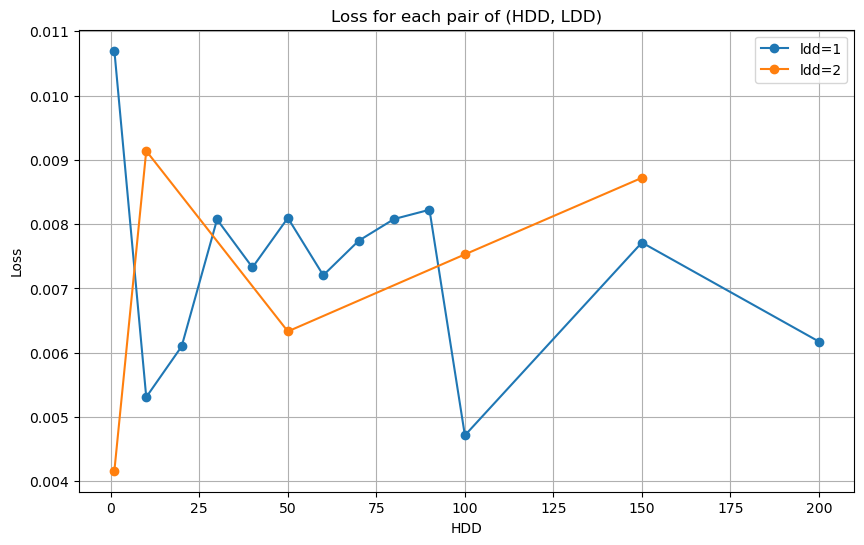

In [4]:

#0.010698 (1,1)
#0.0053098 (10,1)
#0.0060987 (20,1)
#0.008073 (30,1)
#0.007327 (40,1)
#0.008097 (50,1)
#0.0072053 (60,1)
#0.007742 (70,1)
#0.00808 (80,1)
#0.008224 (90,1)
#0.004715 (100,1)
#0.007714 (150,1)
#0.006174 (200,1)

#0.004165 (1,2)
#0.009140 (10,2)
#print(ldd)
#0.006332 (50,2)

#0.007530 (100,2)

#0.008721 (150,2)

# Data: loss values with corresponding (hdd, ldd) pairs
data = [
    (0.010698, (1, 1)), (0.0053098, (10, 1)), (0.0060987, (20, 1)),
    (0.008073, (30, 1)), (0.007327, (40, 1)), (0.008097, (50, 1)),
    (0.0072053, (60, 1)), (0.007742, (70, 1)), (0.00808, (80, 1)),
    (0.008224, (90, 1)), (0.004715, (100, 1)), (0.007714, (150, 1)),
    (0.006174, (200, 1)), (0.004165, (1, 2)), (0.009140, (10, 2)),
    (0.006332, (50, 2)), (0.007530, (100, 2)), (0.008721, (150, 2))
]

# Separate data by ldd value
hdd_1 = [hdd for loss, (hdd, ldd) in data if ldd == 1]
loss_1 = [loss for loss, (hdd, ldd) in data if ldd == 1]

hdd_2 = [hdd for loss, (hdd, ldd) in data if ldd == 2]
loss_2 = [loss for loss, (hdd, ldd) in data if ldd == 2]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(hdd_1, loss_1, marker='o', label="ldd=1")
plt.plot(hdd_2, loss_2, marker='o', label="ldd=2")

# Labels and title
plt.xlabel("HDD")
plt.ylabel("Loss")
plt.title("Loss for each pair of (HDD, LDD)")
plt.legend()
plt.grid(True)
plt.show()


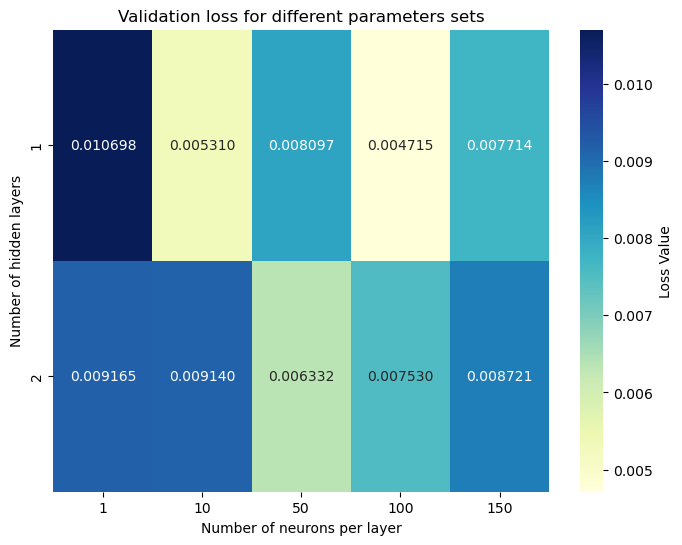

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for neurons, layers, and loss values
data = {
    "neurons": [1, 10, 50, 100, 150, 1, 10, 50, 100, 150],
    "layers": [1, 1, 1, 1, 1, 2, 2, 2, 2, 2],
    "loss": [0.010698, 0.0053098, 0.008097, 0.004715, 0.007714,
             0.009165, 0.009140, 0.006332, 0.007530, 0.008721]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Pivot the data for heatmap
pivot_table = df.pivot(index="layers", columns="neurons", values="loss")

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Loss Value'}, fmt=".6f")
plt.title("Validation loss of the LSTM model for different parameters sets")
plt.xlabel("Number of neurons per layer")
plt.ylabel("Number of hidden layers")
plt.show()
